# Random Parameters Minimization

### Import.

In [1]:
from __future__ import annotations
# from ipynb.fs.full.utils_to_build_QAOAAnsatz import *
from utils_to_build_QAOAAnsatz import *

In [2]:
from datetime import datetime
# import itertools
import math 
# import os
import random
import time
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from scipy.optimize import minimize

#### Funzioni per trovare k.

In [3]:
def truncate(number, n):
    """
    if number has more than n digits -> returns only n digits
    if number is an int              -> returns number
    if number has less than n digits -> returns number
    """
    str_number = str(number)
    
    if not "." in str_number: return number
        
    decimals = str_number.split(".")[1]    
    if len(decimals) == n or len(decimals) < n:
        return number
    else:
        a = int(decimals[n])
        new_number = number - a / (10)**(n+1)
        truncated_number = round(new_number, n)
        return truncated_number
        
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier  

#### Dizionario contenente tutte le k riferite a dimensione 6

In [4]:
k_dict = {'L=n': [0.3333333333333333,   0.5,   0.5,   0.3333333333333333,   0.5,   0.5,   0.5,   
                  0.3333333333333333,   0.25,   0.25],
          'L=max(L_EC)': [0.16666666666666666,   0.16666666666666666,   0.25,   0.16666666666666666,  
                          0.3333333333333333, 0.25,   0.25,   0.16666666666666666,   0.08333333333333333,  
                          0.08333333333333333],
          'L=L_MEC': [0.16666666666666666,   0.16666666666666666,   0.16666666666666666,
                      0.1111111111111111,   0.16666666666666666,   0.16666666666666666,   0.25,   
                      0.16666666666666666,  0.08333333333333333,   0.08333333333333333]}

# Arrotondo per eccesso
k_dict_new = {}
for key,value_list in k_dict.items():
    k_dict_new[key] = [round_up(v, 3) for v in value_list]
k_dict_new

{'L=n': [0.334, 0.5, 0.5, 0.334, 0.5, 0.5, 0.5, 0.334, 0.25, 0.25],
 'L=max(L_EC)': [0.167,
  0.167,
  0.25,
  0.167,
  0.334,
  0.25,
  0.25,
  0.167,
  0.084,
  0.084],
 'L=L_MEC': [0.167,
  0.167,
  0.167,
  0.112,
  0.167,
  0.167,
  0.25,
  0.167,
  0.084,
  0.084]}

### Minimization.

In [10]:
# p = 3 # number of layers
# random_attempts = 20
# init_string = "all1"
p = 1 # number of layers
random_attempts = 1
init_string = "all1"
n = 6

In [19]:
from qiskit import QuantumCircuit
def build_mixing_circuit(n: int, instance: int, verbose: bool = False) -> QuantumCircuit:
    """
    Build the mixing Hamiltonian quantum circuit for the given problem instance.

    This function constructs a mixing operator for the QAOA-style quantum circuit, which
    is used to explore the solution space by applying rotations to the qubits. It returns
    a quantum circuit that implements the mixing evolution.

    Parameters
    ----------
    n : int
        The dimension of the instance, i.e., the number of qubits used for the problem.
    instance : int
        The index or identifier of the specific instance being solved.
    verbose : bool, optional, default=False
        If True, prints additional details during the circuit construction.

    Returns
    -------
    qc_mixing : QuantumCircuit
        The quantum circuit that implements the mixing Hamiltonian evolution, parametrized by beta.
    """
    # Define the problem instance and extract subsets.
    U, subsets_dict = define_instance(n, instance, verbose=verbose)
    subsets = list(subsets_dict.values())
    
    # Extract circuit parameters: intersections, ancillae, and dimension.
    list_of_intersections, num_max_ctrl, NUM_ANC, QC_DIM = get_circuit_parameters(subsets, verbose=verbose)
    
    # Initialize the quantum registers and quantum circuit.
    qr = QuantumRegister(n, 'q')
    anc = QuantumRegister(NUM_ANC, 'ancilla')
    qc_mixing = QuantumCircuit(qr, anc)

    ### Inizializzare le ancille a 1 a ogni strato del QAOA non serve, 
    ### basta inizializzarle una volta sola a p=1 perché su ogni ancilla agisce un  
    ### numero pari di NOT-gate in ogni strato. 
    ### In realtà uno potrebbe inizializzarle in ogni strato per  
    ### proteggersi da eventuali bit-flip. 

    # Initialize ancillas to 1. 
    for ancilla in range(n, QC_DIM):
        qc_mixing.initialize(1, ancilla)
    
    ### Creo una lista di gate che (tramite VChain) implementano  
    ### X-rotazioni con un diverso numero di controlli. L'elemento i 
    ### della lista avrà i+1 controlli. 
    
    # Define the parameter beta for X-rotations.
    beta = Parameter('beta')

    g = [MCMTVChain(RXGate(beta), x, 1) for x in range(1, num_max_ctrl+1)]
    gates = [g[i].to_gate() for i in range(len(g))]
    
    # # Create a list of gates for controlled X-rotations using V-Chain (MCMTVChain).
    # gates = [MCMTVChain(RXGate(beta), num_controls, 1).to_gate() for num_controls in range(1, num_max_ctrl + 1)]

    ### Aggiungo al circuito i gate, specificando quali qubit 
    ### devono fare da controlli: ricorda che l'ordine giusto è  
    ### [controlli, target, ancille] quindi se con 5 qubit [0,1,2,3,4]  
    ### e 2 ancille [5,6] voglio fare una rotazione X su 1  
    ### controllata da 0, 2, 3 scriverò:
    ###  
    ### qc_mixing.append(gates[2], [0,2,3, 1, 5,6]) 

    # Add gates to the quantum circuit.
    for i, intersections in enumerate(list_of_intersections):
        if intersections != []:
            N = len(intersections)
            qubits_list = intersections + [i] + list(range(n, n+N-1))
            qc_mixing.append(gates[N-1], qubits_list)

    if verbose:
        print(f"Mixing circuit created for instance {instance} with {n} qubits.")
        print(f"Circuit dimension (QC_DIM): {QC_DIM}")
        print(f"Number of ancillas: {NUM_ANC}")
        print(f"Number of control gates: {num_max_ctrl}")
    
    return qc_mixing

In [20]:
%matplotlib inline

**************************************************
Instance 4 with h = 0.167

Initialization: all1
PROVA@06-01_dim6_mail4_all1_random_p1_1ra_k0.167_BOUNDS[0,2pi]x[-110,110]_pars0[0,2pi]x[-110,110]
FILENAME: PROVA@06-01_dim6_mail4_all1_random_p1_1ra_k0.167_BOUNDS[0,2pi]x[-110,110]_pars0[0,2pi]x[-110,110].csv

----- 1/1 random_attempts -----

pars_0 = [3.0169745768292633, 12.911264098016588]
bnds = [(0, 6.283185307179586), (-110, 110)]
Optimization terminated successfully.
         Current function value: 0.054155
         Iterations: 50
         Function evaluations: 94
Final parameters (after minimization): betas, gammas = [3.9257543147663045], [-2.2035233226221777e-05]
E_min = res.fun + constant = -0.10338752742880172
***UPDATING THE BEST ENERGY***

        counts_p1_1of1
states                
011001       49.414062
100100        8.398438
001010        7.812500
100000        7.324219
001000        6.933594
ok
ok
ok


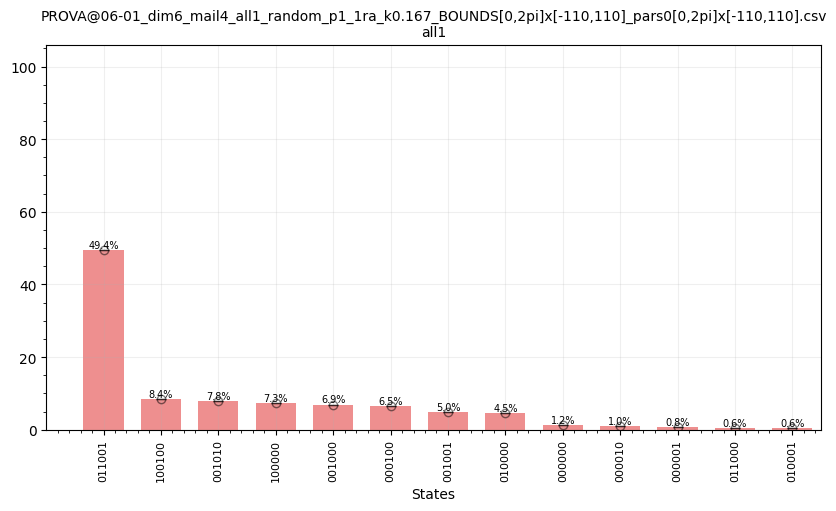


TOTAL ELAPSED TIME: 0.05506051778793335 minutes.


In [22]:
for instance in [4]:
    h = k_dict_new['L=max(L_EC)'][instance-1]
    print("*"*50)
    print(f"Instance {instance} with h = {h}\n")

    
    ### These will contain the files' names.
    FILENAME_list = [] # list of .csv containing the final histograms data.
    DATA_FILENAME_list = [] # list of .txt containing extra data such as energies, betas, gammas.

    
    ### Define the instance.
    U, subsets_dict = define_instance(n, instance, verbose=False)
    subsets = list(subsets_dict.values())
    _, _, states_feasible, energies_feasible, EXACT_COVERS = find_spectrum(U, subsets_dict, n, h)
    MEC = [state for state in EXACT_COVERS if state.count("1") == min([x.count("1")  for x in EXACT_COVERS])]

    # show_spectrum(n, instance, h)

    
    ###########################################################
    
    ### Choose the initialization.
    if init_string == 'all1':
        # Only "1"-states.
        one_one_states = ["".join(elem) for elem in distinct_permutations('0'*(n-1) + '1')]
        init_name = one_one_states

    elif init_string == 'all0':
        init_name = ["000000"]
        print("init_name:", init_name)
    
    ###########################################################    
      
    ### Prepare the cost and mixing circuit.
    constant, hamiltonian, qc_cost = build_cost_circuit(n, instance, h, verbose=False)
    qc_mixing = build_mixing_circuit(n, instance, verbose=False)    
    qc_initial = build_initialization_circuit(n, instance, init_name, verbose=False)
    print(f"Initialization: {init_string}")
    
    ###########################################################
    ###########################################################
    ### SET INITIAL PARAMETERS FOR MINIMIZATION AND BOUNDS
    
    gamma_bound = find_gamma_bound(n, instance, h, verbose=False)
    
    beta_0 = (0, 2*np.pi)
    gamma_0 =  (-gamma_bound, gamma_bound)
    string_0 = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"
    
    bnds_beta = (0, 2*np.pi)
    bnds_gamma = (-gamma_bound, gamma_bound)
    bnds_string = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"
    
    ###########################################################
    ###########################################################
    ### BUILD FILES' NAMES
    
    # current_datetime = datetime.now().strftime("@%Y-%m-%d@%Hh%Mm%Ss")
    current_datetime = datetime.now().strftime("%d-%m")
    
    header = f"PROVA@{current_datetime}_dim{n}_mail{instance}_{init_string}_random_p{p}_{random_attempts}ra_k{h}"
    header = header + f"_BOUNDS{bnds_string}_pars0{string_0}"
    # header = header + f"_BOUNDS_pars0_monotonic"
    print(header)
    
    DATA_FILENAME = header + '_data.txt'
    FILENAME = header + ".csv"
    print("FILENAME:", FILENAME)

    FILENAME_list.append(FILENAME)
    DATA_FILENAME_list.append(DATA_FILENAME)
    
    ###########################################################
    ###########################################################
    ### DO THE MINIMIZATION
    
    
    with open(DATA_FILENAME, 'a') as DATA_FILE:
        DATA_FILE.write(f"current datetime = {datetime.now().strftime('@%Y-%m-%d@%Hh%Mm%Ss')}")
        DATA_FILE.write(f"\np={p}\n")
        DATA_FILE.write(f"\ninit_string: {init_string}\n")
        DATA_FILE.write(f"\ninit_name: {init_name}\n")
    
        E_best = 100
        counter = 0
        TOTAL_start_time = time.time()
    
    
        for i in range(1,random_attempts+1):
            print(f"\n----- {i}/{random_attempts} random_attempts -----\n")
            DATA_FILE.write(f"\n----- {i}/{random_attempts} random_attempts -----\n")

            ### Build QAOAAnsatz.
            cost_vs_iteration = []
            ansatz = QAOAAnsatz(qc_cost, mixer_operator=qc_mixing, initial_state=qc_initial, reps=p, name='my_QAOA_circuit')

            ### Generate a pass manager without providing a backend.
            pm = generate_preset_pass_manager(optimization_level=3)
            ansatz_isa = pm.run(ansatz)
            hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
        
            estimator = StatevectorEstimator()
            sampler = StatevectorSampler()

            
            # *******************************  MINIMIZE  *********************************

            ########################
            ### Do the minimization.
            pars_0 = [random.uniform(*beta_0) for _ in range(p)] + [random.uniform(*gamma_0) for _ in range(p)]  
            bnds = [bnds_beta]*p + [bnds_gamma]*p

            # pars_0_b, pars_0_g, list_of_beta_bnds, list_of_gamma_bnds = find_monotonic_pars_0(beta_0, gamma_0)
            # pars_0 = pars_0_b + pars_0_g
            # bnds = list_of_beta_bnds + list_of_gamma_bnds
            
            print(f"pars_0 = {pars_0}")
            print(f"bnds = {bnds}")
            ########################
            
            ### If you wnat to plot iterations you should choose cost_func_plot
            
            # res = minimize(cost_func, pars_0,
            #                args=(ansatz_isa, hamiltonian_isa, estimator), 
            #                method="COBYLA", options={"maxiter":200, "tol":1e-3})
            res = minimize(cost_func, pars_0, bounds=bnds,
                           args=(ansatz_isa, hamiltonian_isa, estimator), 
                           method="Nelder-Mead", options={"disp": True, "maxiter": 1200, "maxfev": 1200}, tol=1e-4)
            # res = minimize(cost_func, pars_0, bounds=bnds,
            #                args=(ansatz_isa, hamiltonian_isa, estimator), 
            #                method="Nelder-Mead", tol=1e-4)
            # The default value is method specific. For example for Nelder-Mead they are xatol=1e-4, fatol=1e-4

            if cost_vs_iteration != []:
                ### Plot of iterations. 
                ### Works only if you chose the cost_func that plots iteration.
                plt.figure(figsize=(7, 4))
                plt.rcParams['font.size'] = 13
                plt.plot(cost_vs_iteration)
                plt.xlabel("Iteration")
                plt.ylabel("Cost")
                plt.show()
            
            ### Select the optimal parameters (betas,gammas) found.
            betas = list(res.x[:p])
            gammas = list(res.x[p:])
            print(f"Final parameters (after minimization): betas, gammas = {betas}, {gammas}")

            ### Minimum cost (energy) reached with minimization.
            E_min = res.fun + constant
            print(f"E_min = res.fun + constant = {E_min}")
            # E_min = res.fun -A -B  
            # print(f"E_min = res.fun - A - B = {E_min}")
            
            DATA_FILE.write(f"\nE_min = {E_min}")
            DATA_FILE.write(f'\nE_min\'s parameters: betas = {betas}, gammas = {gammas}\n')

            ### Update the lowest energy solution index "i".
            if E_min < E_best:
                    E_best = E_min
                    i_best = i 
                    print("***UPDATING THE BEST ENERGY***\n")
            else:
                print("***NOT UPDATING***\n")
        
                    
            # ****************************  RUN THE CIRCUIT  ******************************
            ### Assign to the ansatz the 2p parameters found, then run the circuit.
            pars = betas + gammas
            qc = ansatz.assign_parameters(pars)
            qc.measure_all()
            qc_isa = pm.run(qc)
            result = sampler.run([qc_isa], shots=1024).result()
            samp_dist = result[0].data.meas.get_counts()
       
            
            # ****************************  POST PROCESS  **********************************
            # Create a dataframe out of the sampling's results.
            df = pd.DataFrame(samp_dist.items()).rename(columns={0: 'states', 1: 'counts'})
            _, _, NUM_ANC, _ = get_circuit_parameters(subsets, verbose=False)
            df['states'] = df['states'].apply(lambda x: x[NUM_ANC:]) # remove ancillary bits
            df = df.groupby(['states']).sum()
            
            # Create a dictionary with states and occurrences.
            d = df['counts'].to_dict()
            lists = sorted(d.items(), key=lambda item: item[1], reverse=True)
        
            # Invert bit order ("01101 -> 10110")      
            d = invert_counts(d)
        
            
            # **************************** PLOT THE i-TH DATAFRAME ****************************
            # plt.figure(figsize=(15,5))
            # plt.rcParams['font.size'] = 13
            # plt.title(f"Ansatz with p={p}, {i} of {random_attempts}")
            # plt.ylim(0,1024)
            # plt.grid()
            df = pd.DataFrame(d.items())
            df = df.rename(columns={0: 'states', 1: f'counts_p{p}_{i}of{random_attempts}'})    
            df = df.sort_values(f'counts_p{p}_{i}of{random_attempts}', ascending=False) 
            # plot_histogram_of_df_column(df, f'counts_p{p}_{i}of{random_attempts}', EXACT_COVERS, init_name, title='')
            # ax = sns.barplot(x='states', y=f'counts_p{p}_{i}of{random_attempts}', data=df)
            
            # # Make labels with percentages.
            # labels = df[f'counts_p{p}_{i}of{random_attempts}'].apply(lambda x: (x/df[f'counts_p{p}_{i}of{random_attempts}'].sum())*100).round(1).astype('str') + '%'
            # for container in ax.containers:
            #     ax.bar_label(container, labels=labels, fontsize=11)
                
            # # Highlight with red the exact covers
            # highlight_correct_ticks(ax, EXACT_COVERS)
            # plt.show()
    
            # Merge dataframes.
            if i == 1:
                df_final = df
            else:
                df_final = pd.merge(df_final, df, on="states", how="outer")    
    
            # if df['states'].iloc[0] == MEC:    
            #     DATA_FILE.write("\n### Most frequent state is MEC ###\n")
            #     counter += 1
        
        # ################### SAVE TO CSV AND FIX BETA,GAMMA ###################
        # Save to csv.
        df_final.to_csv(FILENAME, index=False)
        title = FILENAME +"\n"+ init_string
        plot_histogram_of_best_column(df_final, f'counts_p{p}_{i_best}of{random_attempts}', EXACT_COVERS, init_name, title=title)
        
        ######################################################################
        DATA_FILE.write("\n*******************************")
        DATA_FILE.write(f"\nAttempt that reached the best result with E_min = {E_best} is #{i_best} ")
        DATA_FILE.write(f"\nMost frequent state was MEC / random attempts = {counter} / {random_attempts} = {round((counter/random_attempts)*100, 1)}%\n")
        
    
        print(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.")
        DATA_FILE.write(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.\n")

## Read files.

#### Stampa UN SOLO file che contiene una sottostringa.

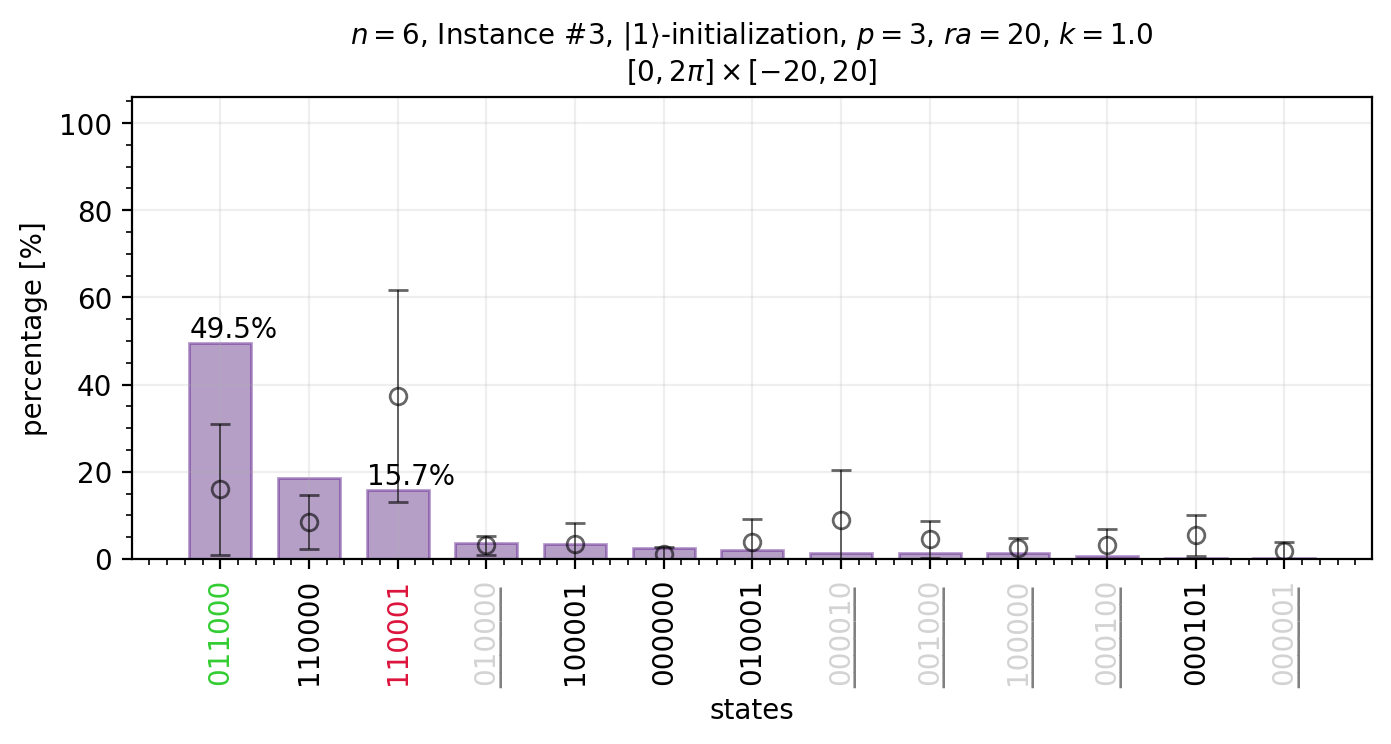

In [4]:
# Find the files that contain a substring in a certain path.
substrings = ["all1", "mail3"]
path = "./FILES_PER-IMMAGINI-LATEX/tutte-le-istanze_all0_all1_20ra/"
FILENAME_list, DATA_FILENAME_list = find_files_containing_string(substrings, path)


# Select only the first file.
FILENAME = FILENAME_list[0]
DATA_FILENAME = DATA_FILENAME_list[0]


# Plot.
plot_file(FILENAME, DATA_FILENAME, colorchosen='indigo', alpha=0.4,
          dont_show_in_title = [], 
          figsize=(8, 3), dpi=200, N=10)

#### Stampa DIVERSI file che contengono una sottostringa

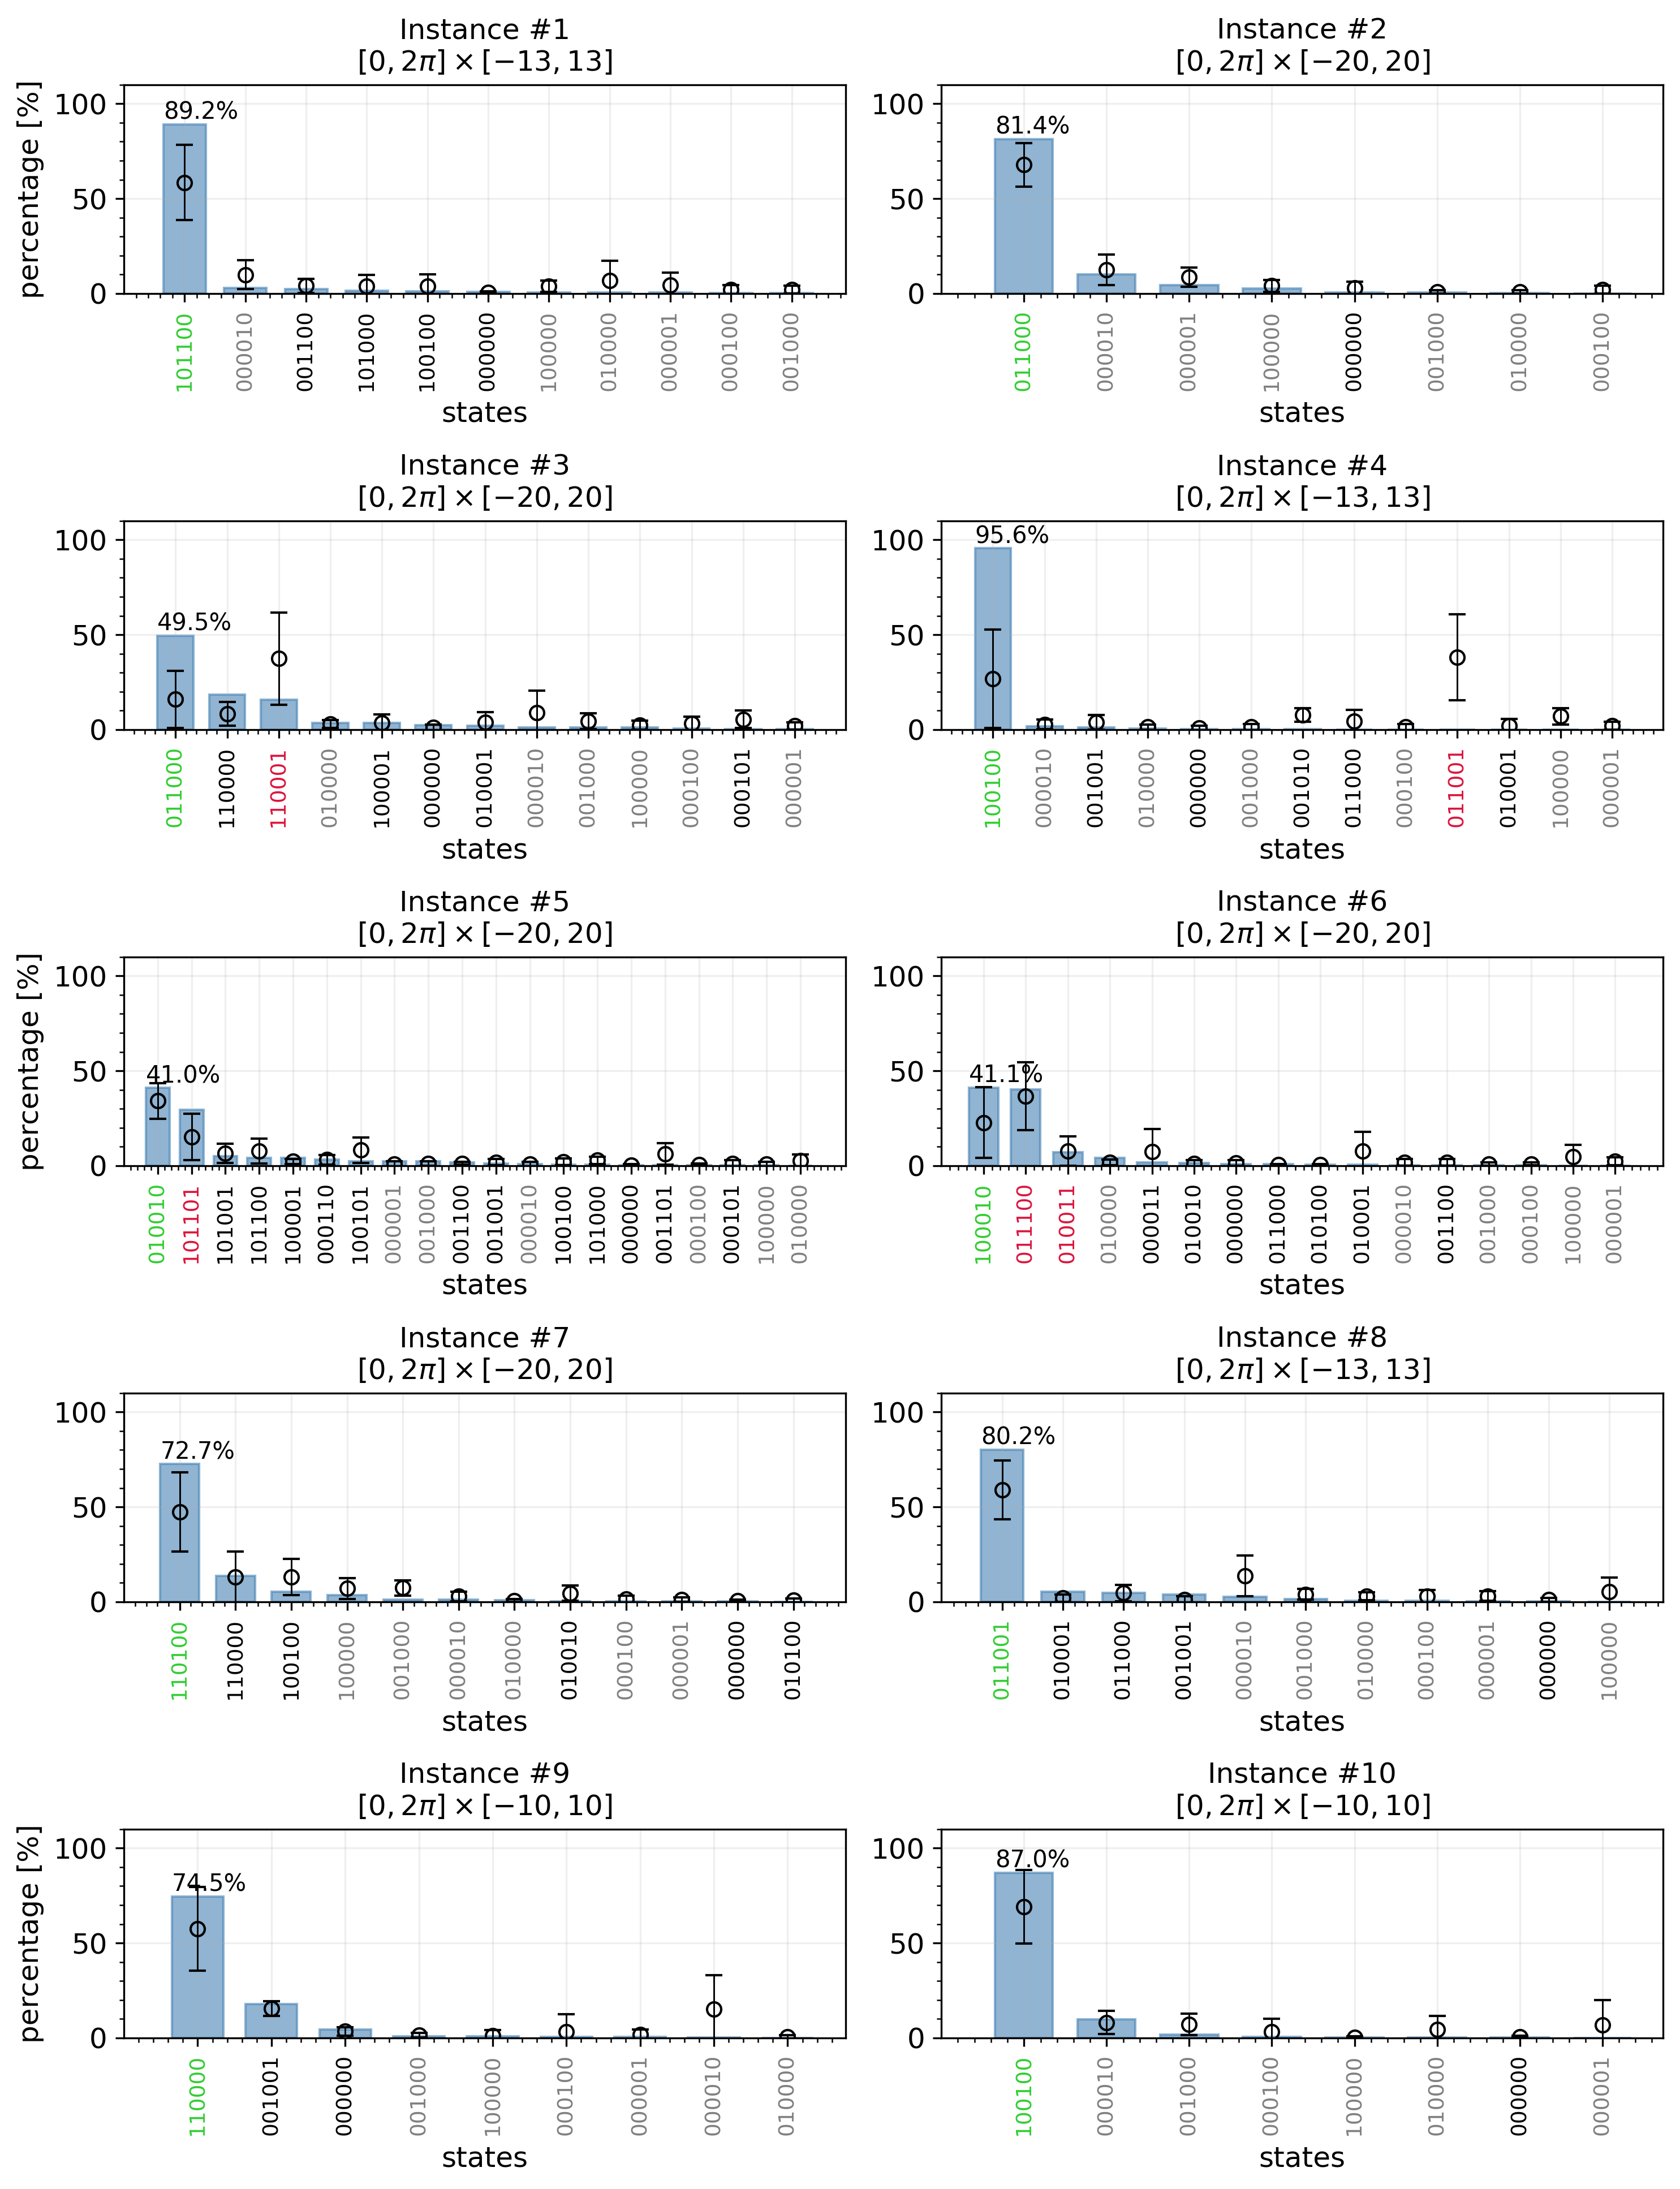

In [30]:
# Find files that contain a substring in a certain path.
substrings = ["all1"]
path = "./FILES_PER-IMMAGINI-LATEX/tutte-le-istanze_all0_all1_20ra/"
# path = "./FILES_PER-IMMAGINI-LATEX/varie_k_tol1e4_all1/"
FILENAME_list, DATA_FILENAME_list = find_files_containing_string(substrings, path)

# Plot
plot_list_of_files(FILENAME_list, DATA_FILENAME_list, colorchosen="steelblue", alpha=0.6,
                   init_name="all1",
                   dont_show_in_title=["i", "k"], 
                   dont_show_in_titles=["n", "p", "ra", "k", "init"], 
                   figsize=(10, 13), dpi=300, N=12)

### funzione che stampa un subplot per ogni istanza. in ogni subplot mette piu barplot di colore diverso in base a  "order"

### Plot  di all0 vs all1 con random parameters

Processing instance 1
Processing instance 2
Processing instance 3
Processing instance 4
Processing instance 5
Processing instance 6
Processing instance 7
Processing instance 8
Processing instance 9
Processing instance 10


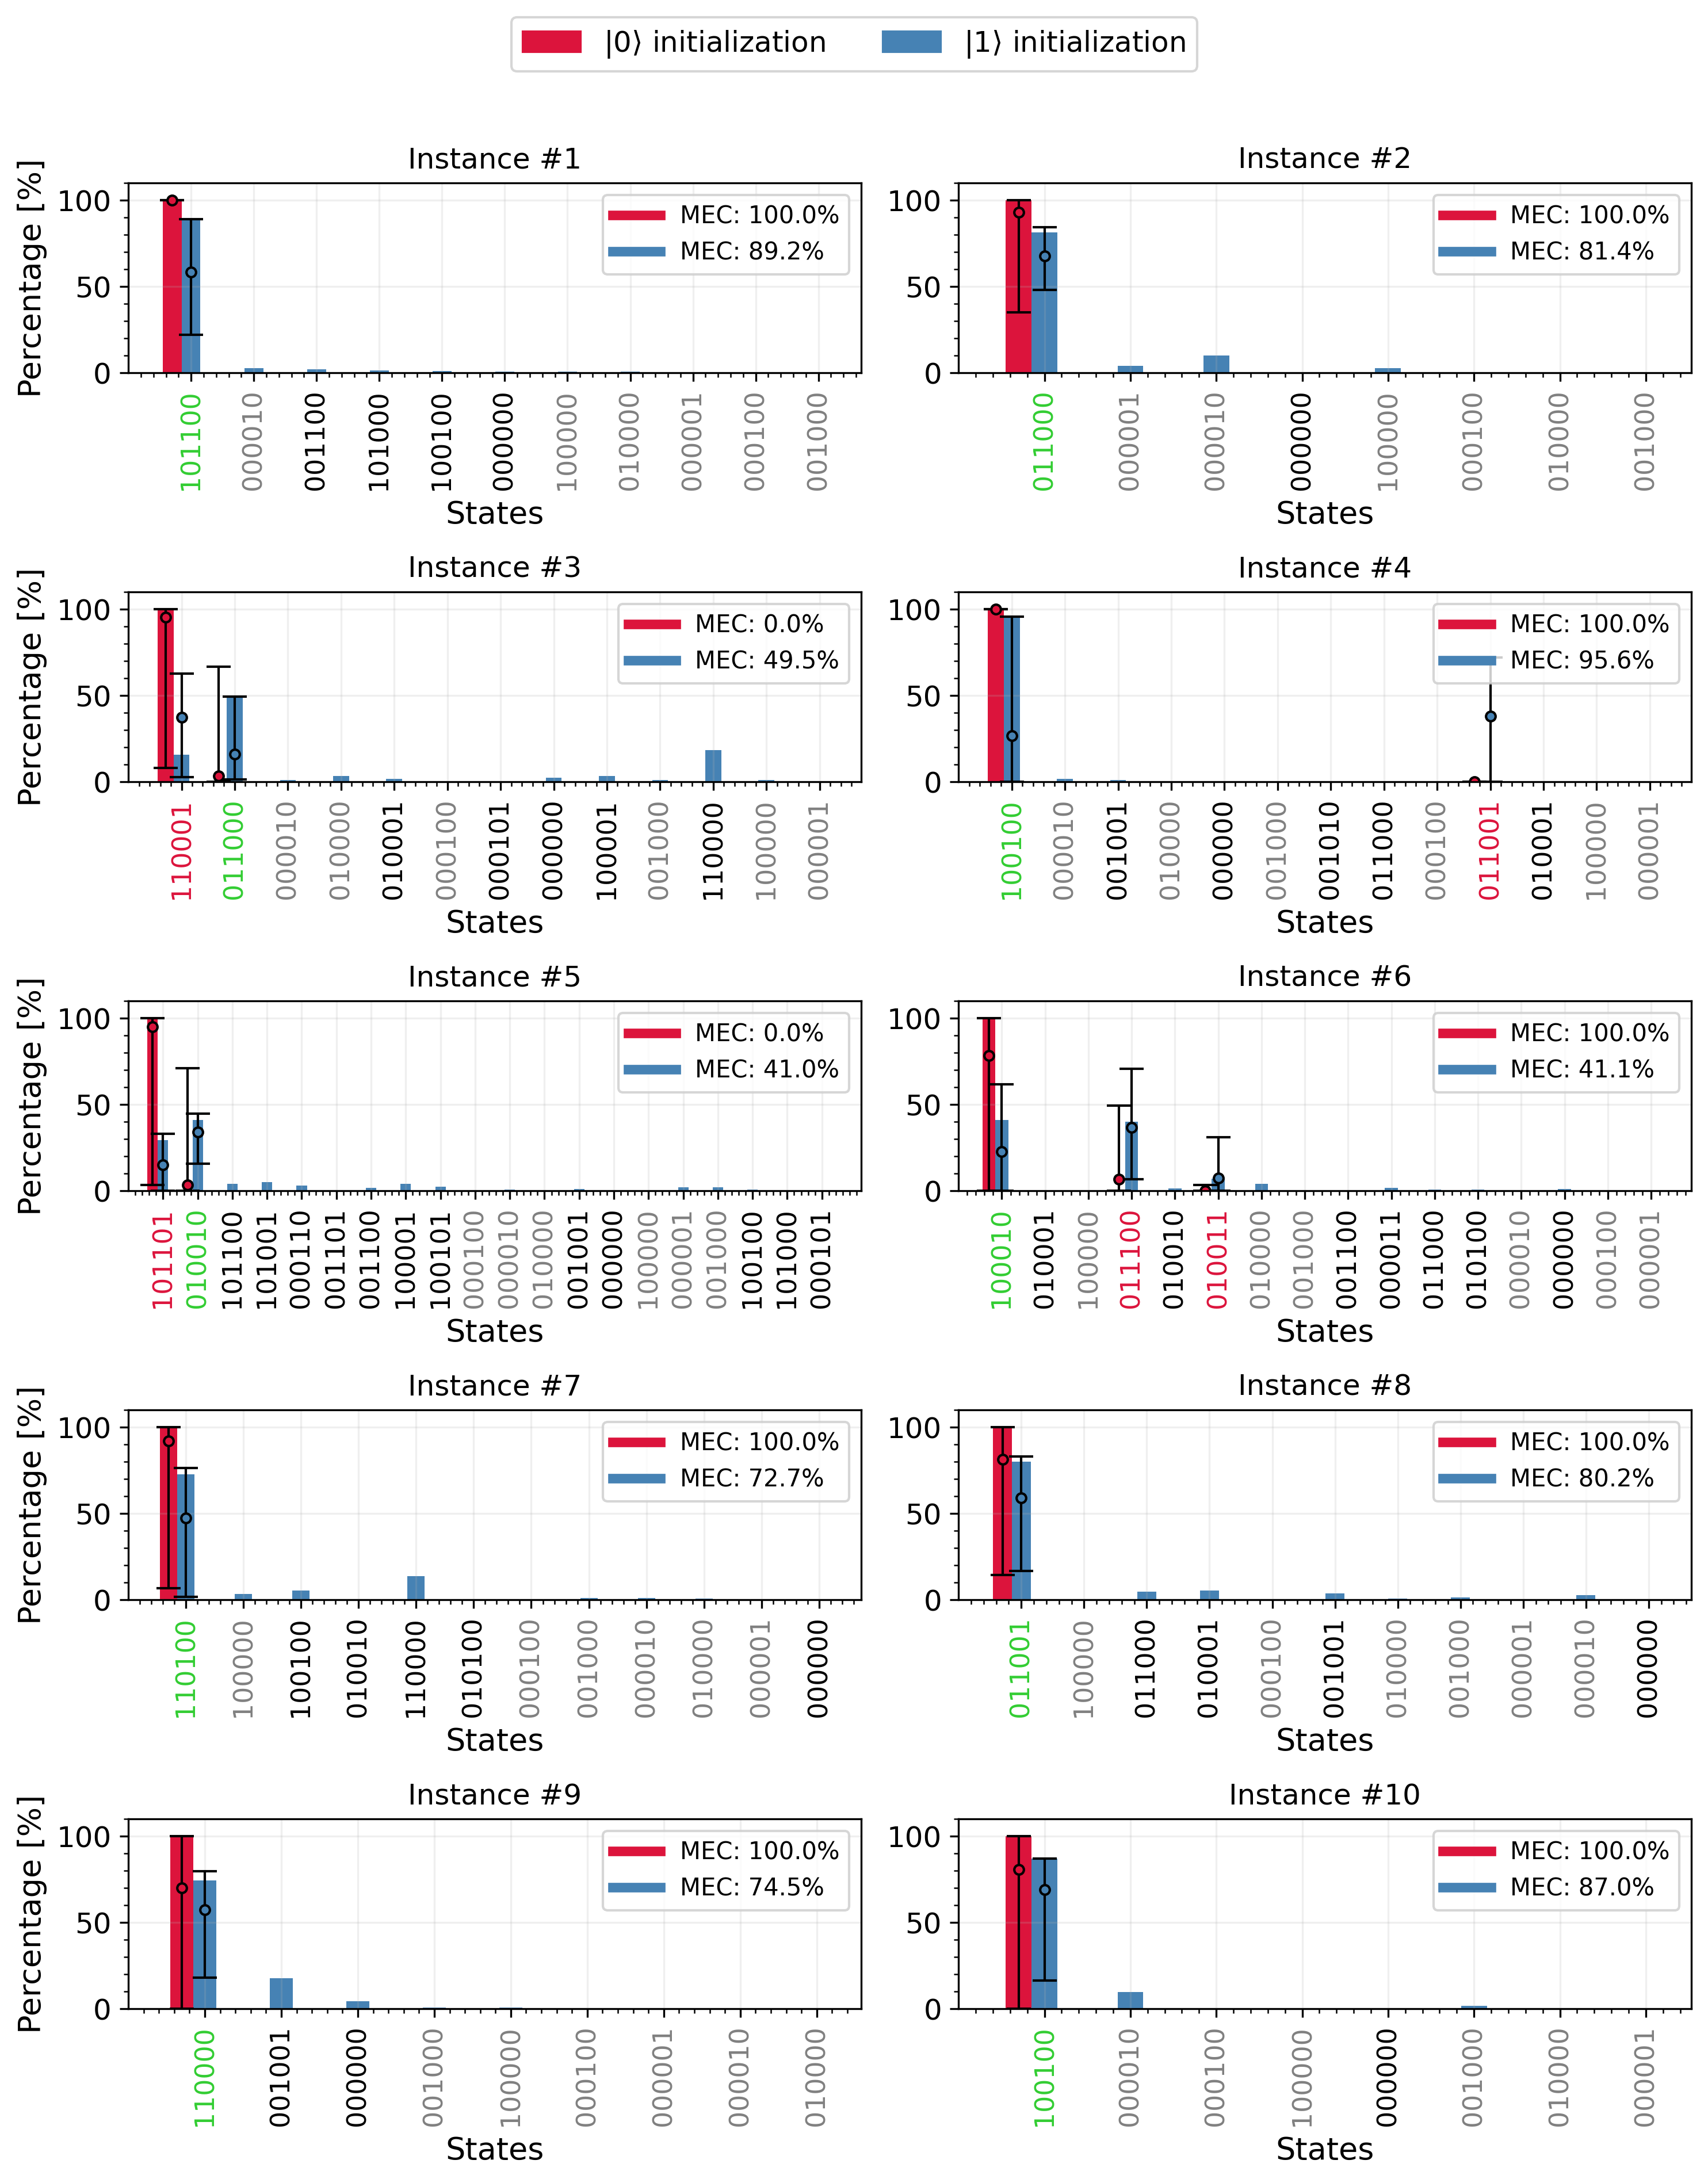

In [3]:
multiple_barplot(path = "./FILES_PER-IMMAGINI-LATEX/tutte-le-istanze_all0_all1_20ra/",
                 string_order = [ 'all1', 'all0'],
                 order_labels = ['$all1$', '$all0$'],
                 color_map = {"$|0\\rangle$ initialization": 'crimson', "$|1\\rangle$ initialization": 'steelblue'},
                 filename_to_save = "all0_all1_random.pdf",
                 show_title=False)

### Plot di confronto tra varie k

1
2
3
4
5
6
7
8
9
10


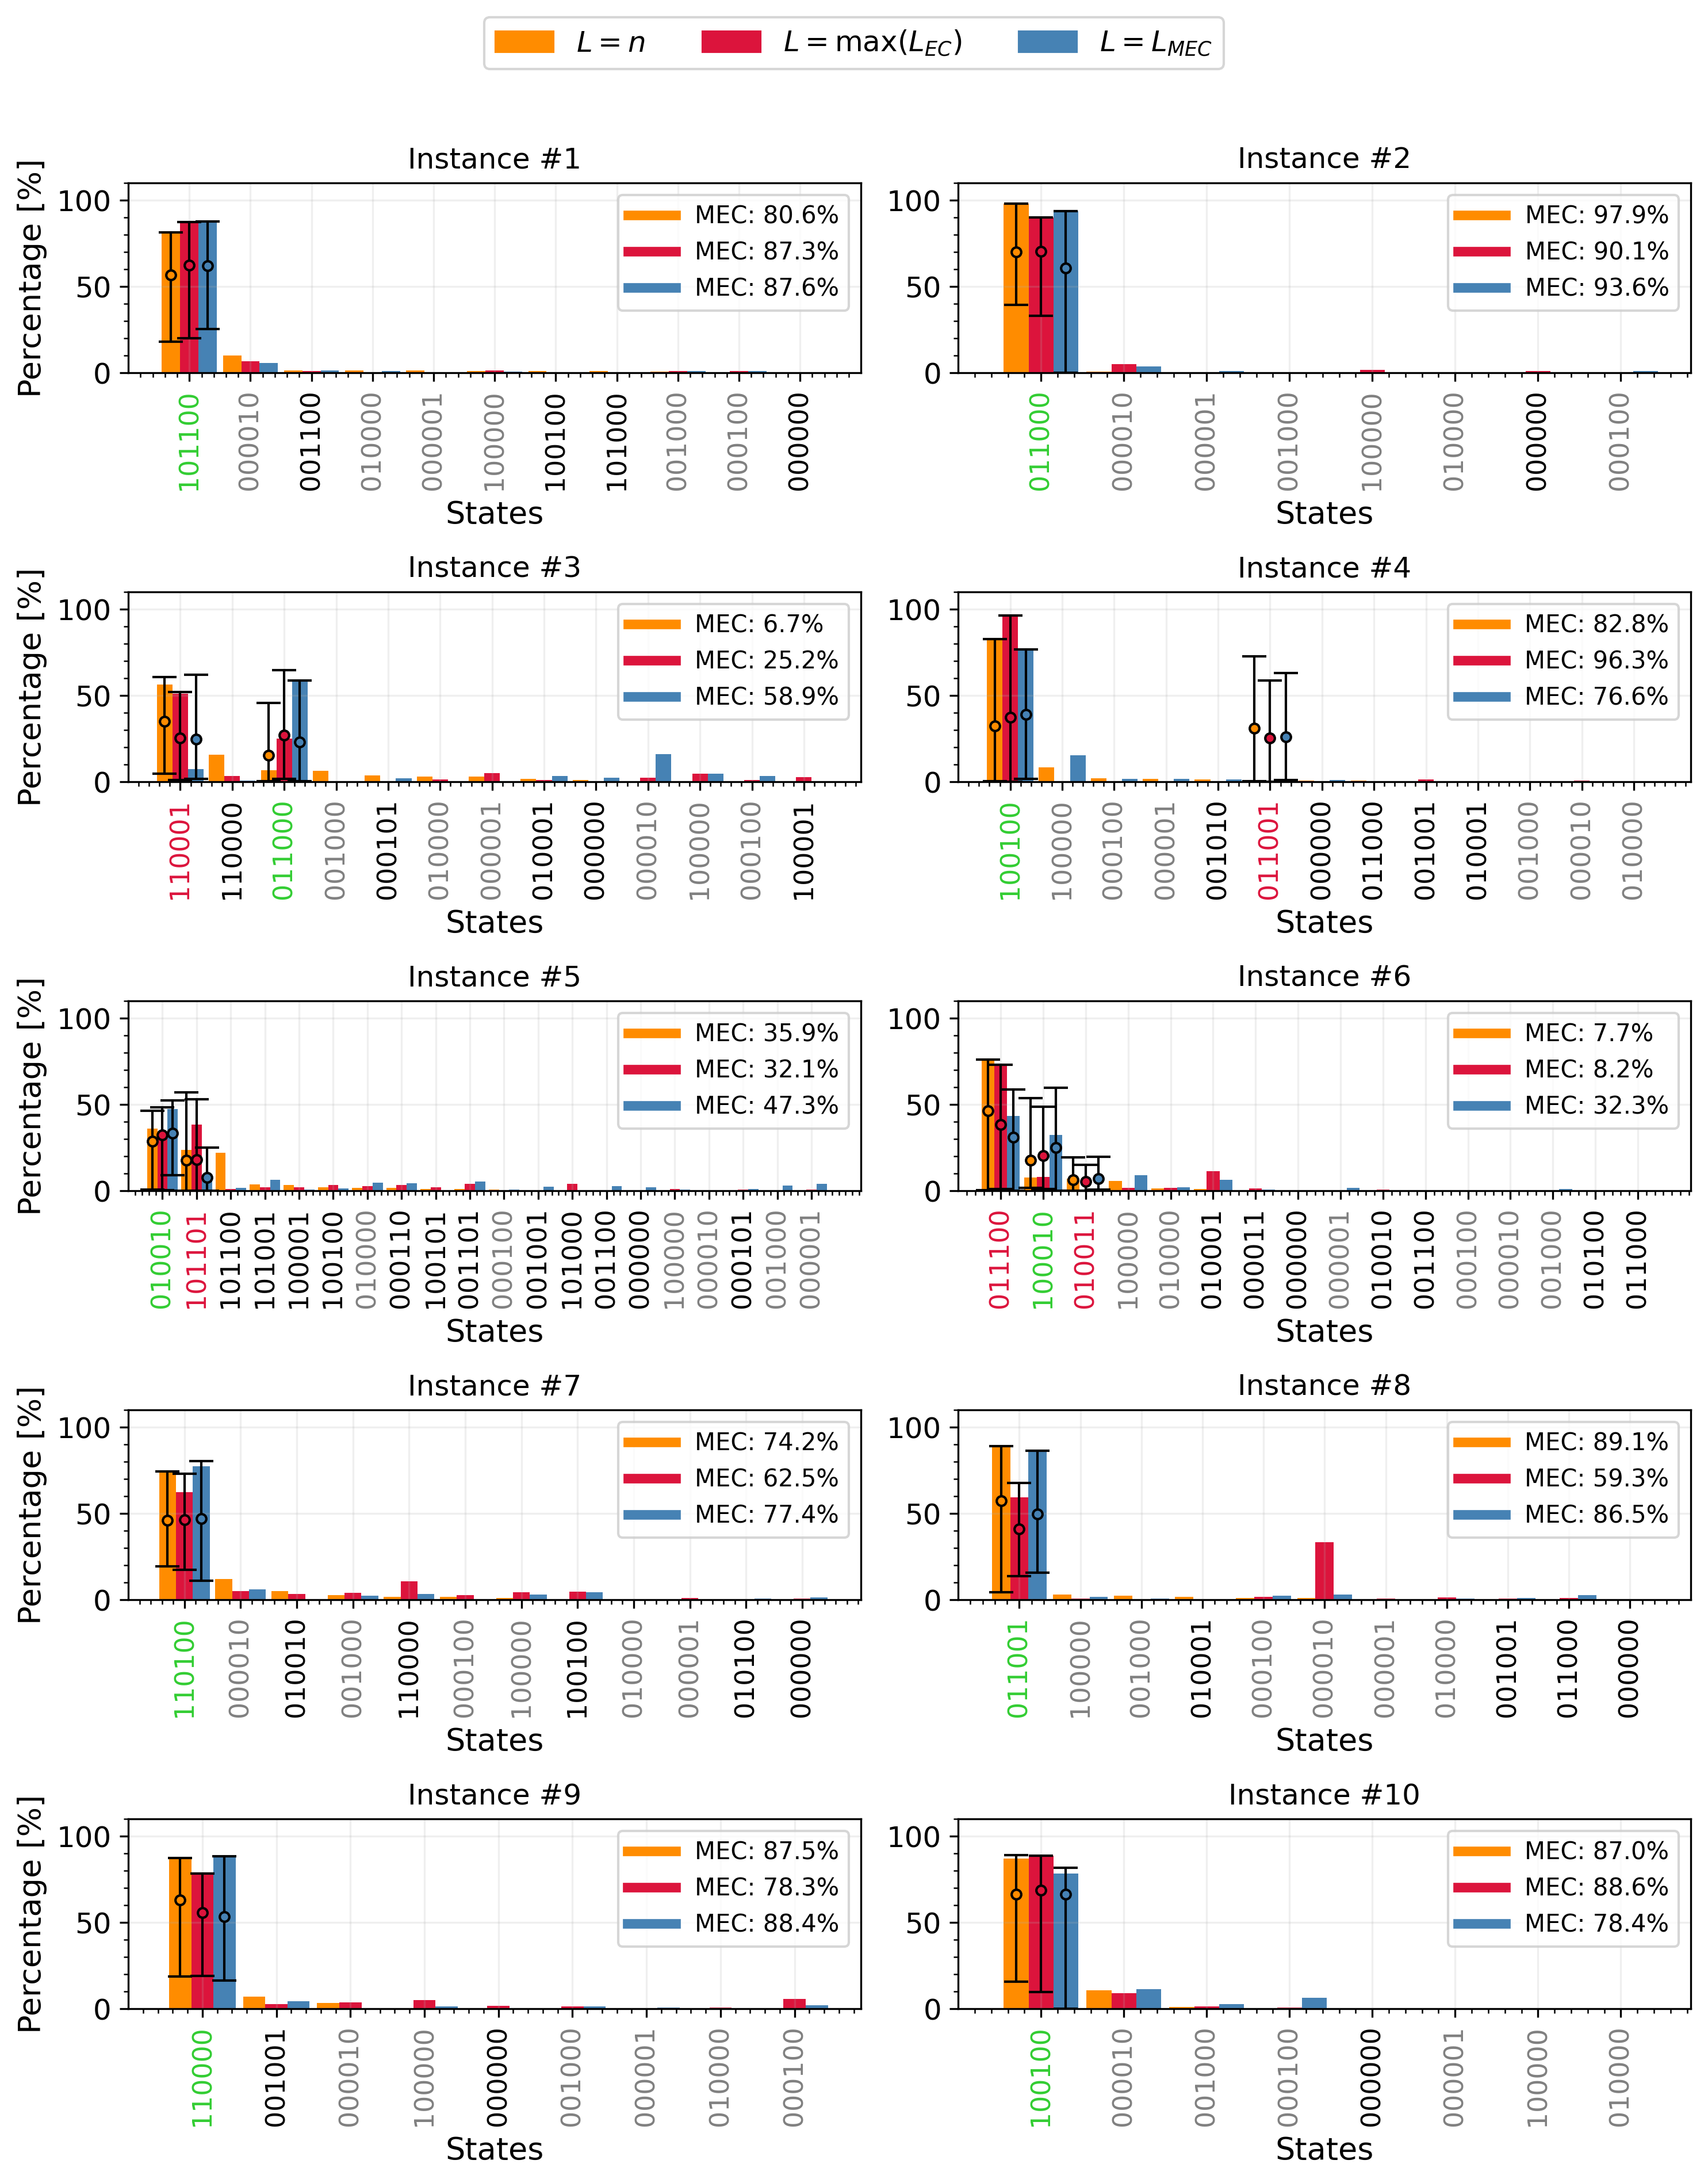

In [135]:
multiple_barplot(path = "./FILES_PER-IMMAGINI-LATEX/varie_k_options_tol1e4_all1/",
                 string_order = ['L=n', 'maxLEC', 'LMEC'],
                 order_labels = ['$L=n$', '$L=$max($L_{EC}$)', '$L=L_{MEC}$'],
                 color_map = {'$L=n$': 'darkorange', '$L=$max($L_{EC}$)': 'crimson', '$L=L_{MEC}$': 'steelblue'},
                 filename_to_save = "performance_k.pdf",
                 show_title = False)